# Wide and Deep Model for LIBIS Recommendations

<br>

A linear model with a wide set of crossed-column (co-occurrence) features can memorize the feature interactions, while deep neural networks (DNN) can generalize the feature patterns through low-dimensional dense embeddings learned for the sparse features. [**Wide-and-deep**](https://arxiv.org/abs/1606.07792) learning jointly trains wide linear model and deep neural networks to combine the benefits of memorization and generalization for recommender systems.

This notebook shows how to build and test the wide-and-deep model using [TensorFlow high-level Estimator API](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNLinearCombinedRegressor). With the [movie recommendation dataset](https://grouplens.org/datasets/movielens/), we quickly demonstrate following topics:
1. How to prepare data
2. Build the model
3. Use log-hook to estimate performance while training
4. Test the model and export

To run project, first install it by running:
pip install .
pip install -e .[examples]
pip install tensorflow-gpu==1.15.0

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math
import os
from tempfile import TemporaryDirectory

import scrapbook as sb
import pandas as pd
import sklearn.preprocessing
import tensorflow as tf

tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.constants import (
    DEFAULT_LIBIS_USER_COL as USER_COL,
    DEFAULT_LIBIS_ITEM_COL as ITEM_COL,
    DEFAULT_LIBIS_RATING_COL as RATING_COL,
    DEFAULT_PREDICTION_COL as PREDICT_COL,
    DEFAULT_LIBIS_GENRE_COL as ITEM_FEAT_COL,
    SEED
)
from recommenders.utils import tf_utils, gpu_utils, plot
from recommenders.datasets.pandas_df_utils import user_item_pairs
from recommenders.datasets.python_splitters import python_random_split
import recommenders.evaluation.python_evaluation as evaluator
import recommenders.models.wide_deep.wide_deep_utils as wide_deep

from datetime import datetime
from dateutil.relativedelta import relativedelta

print("Tensorflow Version:", tf.__version__)
print("GPUs:\n", gpu_utils.get_gpu_info())

Tensorflow Version: 1.15.0
GPUs:
 [{'device_name': 'NVIDIA GeForce GTX 1070', 'total_memory': 8191.6875, 'free_memory': 7243.3125}]


In [3]:
"""Parameters (papermill)"""

# Recommend top k items
TOP_K = 10
# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'
# Metrics to use for evaluation
RANKING_METRICS = [
    evaluator.ndcg_at_k.__name__,
    evaluator.precision_at_k.__name__,
]
RATING_METRICS = [
    evaluator.rmse.__name__,
    evaluator.mae.__name__,
]
# Use session hook to evaluate model while training
EVALUATE_WHILE_TRAINING = True

RANDOM_SEED = SEED  # Set seed for deterministic result

# Train and test set pickle file paths. If provided, use them. Otherwise, download the MovieLens dataset.
DATA_DIR = None
TRAIN_PICKLE_PATH = None
TEST_PICKLE_PATH = None
EXPORT_DIR_BASE = '.\outputs\model'
# Model checkpoints directory. If None, use temp-dir.
MODEL_DIR = 'C:\\Users\\kazim\\Sources\\senvaitis\\recommenders\\examples\\00_quick_start\\outputs\\tensorboard'
# MODEL_DIR = '.\tensorflowlogs'
# os.makedirs(EXPORT_DIR_BASE, exist_ok=True)
# os.makedirs(MODEL_DIR, exist_ok=True)

#### Hyperparameters
MODEL_TYPE = 'wide_deep'
STEPS = 50000  # Number of batches to train
BATCH_SIZE = 32
# Wide (linear) model hyperparameters
LINEAR_OPTIMIZER = 'adagrad'
LINEAR_OPTIMIZER_LR = 0.0621  # Learning rate
LINEAR_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
LINEAR_L2_REG = 0.0
LINEAR_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer
# DNN model hyperparameters
DNN_OPTIMIZER = 'adadelta'
DNN_OPTIMIZER_LR = 0.1
DNN_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
DNN_L2_REG = 0.0
DNN_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer
# Layer dimensions. Defined as follows to make this notebook runnable from Hyperparameter tuning services like AzureML Hyperdrive
DNN_HIDDEN_LAYER_1 = 0     # Set 0 to not use this layer
DNN_HIDDEN_LAYER_2 = 64    # Set 0 to not use this layer
DNN_HIDDEN_LAYER_3 = 128   # Set 0 to not use this layer
DNN_HIDDEN_LAYER_4 = 512   # Note, at least one layer should have nodes.
DNN_HIDDEN_UNITS = [h for h in [DNN_HIDDEN_LAYER_1, DNN_HIDDEN_LAYER_2, DNN_HIDDEN_LAYER_3, DNN_HIDDEN_LAYER_4] if h > 0]
DNN_USER_DIM = 32          # User embedding feature dimension
DNN_ITEM_DIM = 16          # Item embedding feature dimension
DNN_DROPOUT = 0.8
DNN_BATCH_NORM = 1         # 1 to use batch normalization, 0 if not.

In [4]:
if MODEL_DIR is None:
    TMP_DIR = TemporaryDirectory()
    model_dir = TMP_DIR.name
else:
    if os.path.exists(MODEL_DIR) and os.listdir(MODEL_DIR):
        raise ValueError(
            "Model exists in {}. Use different directory name or "
            "remove the existing checkpoint files first".format(MODEL_DIR)
        )
    TMP_DIR = None
    model_dir = MODEL_DIR

### 1. Prepare Data

#### 1.1 Movie Rating and Genres Data
First, download [MovieLens](https://grouplens.org/datasets/movielens/) data. Movies in the data set are tagged as one or more genres where there are total 19 genres including '*unknown*'. We load *movie genres* to use them as item features.

In [5]:
# declare constants
DATASET = '100k'
# DATASET = '1m'
# DATASET = '5m'
# DATASET = '10m'
# DATASET = '20m'

MAX_ORDER_AGE_IN_MONTHS = 12
NUM_NEGATIVES = 4
# NUM_CLUSTERS = 10

In [6]:
use_preset = (TRAIN_PICKLE_PATH is not None and TEST_PICKLE_PATH is not None)
if not use_preset:
    # The genres of each movie are returned as '|' separated string, e.g. "Animation|Children's|Comedy".
    data = pd.read_csv(r'data/libis/' + DATASET + '/u.order-' + str(NUM_NEGATIVES) + '-negatives', sep=',',
                     parse_dates=['timestamp'])
    data = data[['user_id', 'record_id', 'timestamp', 'order_count']]
    print("order count BEFORE dropping outdated orders: {}".format(len(data)))
    data = data[data['timestamp'] > (datetime.now() - relativedelta(months=MAX_ORDER_AGE_IN_MONTHS))]
    data = data[['user_id', 'record_id', 'order_count']]

    records = pd.read_csv(r'data/libis/' + DATASET + '/u.record', sep=',')
    records = records[['id', 'title', 'genres']]

    data = pd.merge(data, records, left_on='record_id', right_on='id', how='left')

    # data = libis.load_pandas_df(
    #     size=MOVIELENS_DATA_SIZE,
    #     header=[USER_COL, ITEM_COL],
    #     genres_col=ITEM_FEAT_COL
    # )
    # set genres to 'Unknown', where genres is NaN
    # data['genres'].loc[np.isnan(data['genres'])] = 'Unknown'
    # data[data['genres'].isnull()] = 'Unknown'
    data["genres"].fillna("Unknown", inplace = True)

    display(data.sample(10))


order count BEFORE dropping outdated orders: 400446


,user_id,record_id,order_count,id,title,genres
75381,280,945,0,945,Muminukas ir žvaigždė : [pasakojimas] pagal or...,Grožinė literatūra vaikams ir jaunimui
245321,868,1925,1,1925,Šešėlyje : [romanas] / Diane Chamberlain. – Vi...,Grožinė literatūra
214272,754,320,0,320,Skrybėlaičių karalienė : romanas / Natalie Meg...,Grožinė literatūra
177912,644,1069,0,1069,Džiovintas debesėlis : pasakos / rašė Nijolė K...,Grožinė literatūra vaikams ir jaunimui
107999,391,1953,0,1953,Už uždarų durų : [detektyvinis romanas] / Eliz...,Grožinė literatūra
37157,165,1444,0,1444,Emigrantai : ar braškės virsta ferariais? : bi...,Grožinė literatūra
48808,205,1995,0,1995,Pašėlusi auklė ir didysis traukinio gelbėjimas...,Grožinė literatūra vaikams ir jaunimui
262989,925,1258,0,1258,Pasiklyskime : romanas / Adi Alsaid. – Vilnius...,Grožinė literatūra vaikams ir jaunimui
292191,1047,212,0,212,Tu priklausai man : romanas / Mary Higgins Cla...,Grožinė literatūra
215487,756,1350,0,1350,Seserų varpai : romanas / Lars Mytting. – Viln...,Grožinė literatūra


#### 1.2 Encode Item Features (Genres)
To use genres from our model, we multi-hot-encode them with scikit-learn's [MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html).

For example, *Movie id=2355* has three genres, *Animation|Children's|Comedy*, which are being converted into an integer array of the indicator value for each genre like `[0, 0, 1, 1, 1, 0, 0, 0, ...]`. In the later step, we convert this into a float array and feed into the model.

> For faster feature encoding, you may load ratings and items separately (by using `movielens.load_item_df`), encode the item-features, then combine the rating and item dataframes by using join-operation. 

In [7]:
if not use_preset and ITEM_FEAT_COL is not None:
    # Encode 'genres' into int array (multi-hot representation) to use as item features
    genres_encoder = sklearn.preprocessing.MultiLabelBinarizer()
    data[ITEM_FEAT_COL] = genres_encoder.fit_transform(
        data[ITEM_FEAT_COL].apply(lambda s: s.split("|"))
    ).tolist()
    print("Genres:", genres_encoder.classes_)
    display(data.head())

Genres: ['Bendrasis skyrius' 'Biografijos' 'Demografija. Sociologija. Statistika'
 'Etnografija. Papročiai. Tautosaka' 'Filosofija, psichologija'
 'Gamtos mokslai' 'Geografija' 'Grafika. Graviūra' 'Grožinė literatūra'
 'Grožinė literatūra vaikams ir jaunimui' 'Istorija' 'Kalbotyra'
 'Kino menas. Masinės šventės'
 'Literatūros kritika ir literatūros mokslas' 'Medicina'
 'Namų ūkis. Komunalinis ūkis. Buities tarnyba'
 'Pažintinė literatūra vaikams'
 'Piešimas. Taikomoji dekoratyvinė dailė. Dizainas' 'Politika'
 'Religija, teologija'
 'Socialinis aprūpinimas ir socialinė pagalba. Draudimas'
 'Teatras. Scenos menas' 'Teisė. Teisės mokslai'
 'Valstybės administracinis valdymas. Karyba'
 'Visuomenės mokslų teorija ir metodai' 'Zoologija'
 'Įmonių valdymas. Gamybos, prekybos ir transporto organizavimas'
 'Šventės. Choreografija'
 'Švietimas. Ugdymas. Mokymas. Laisvalaikio organizavimas'
 'Žaidimai. Sportas']


,user_id,record_id,order_count,id,title,genres
0,1,455,1,455,Ruduo Berlyne : [romanas] / Lina Ever. – Vilni...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,1,1272,1,1272,Trapumas : romanas / Jodi Picoult. – Vilnius :...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,1,1982,1,1982,Kuždesių fontanas : [romanas] / Ruta Sepetys. ...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
3,1,530,1,530,Tūkstantis saulių skaisčių : [romanas] / Khale...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,1,566,1,566,Ir aidėjo kalnai : [romanas] / Khaled Hosseini...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


#### 1.3 Train and Test Split

In [8]:
if not use_preset:
    train, test = python_random_split(data, ratio=0.8, seed=RANDOM_SEED)
    # # generate negative samples START
    # user_item_label_set = set(zip(train['user_id'], train['record_id'], train['order_count']))
    # user_item_set = set(zip(train['user_id'], train['record_id']))
    # GENERATE_NUM_NEGATIVES = 4
    # all_record_ids = train['record_id'].unique()
    # negative_train = []
    # record_id_to_genres_dic = train[['record_id', 'genres']].drop_duplicates(subset=['record_id'])
    # print(record_id_to_genres_dic.shape)
    # for u, i, l in tqdm(user_item_label_set):
    #     for _ in range(GENERATE_NUM_NEGATIVES):
    #         #print('in nested for')
    #         random_negative_item_id = np.random.choice(all_record_ids)
    #         #evaluating_expression = orders.loc[(orders['user_id'] == u) & (orders['record_id'] == random_negative_item_id)].bool()
    #         #print('evaluating_expression', evaluating_expression)
    #         while (u, random_negative_item_id) in user_item_set:
    #             #print('generating another random negative')
    #             random_negative_item_id = np.random.choice(all_record_ids)
    #         #print('escaped')
    #         random_negative_item_genres = record_id_to_genres_dic[record_id_to_genres_dic.record_id == random_negative_item_id].iloc[0].genres
    #         negative_train.append({'user_id': u, 'record_id': random_negative_item_id, 'genres':random_negative_item_genres, 'order_count': 0})
    # train = train.append(negative_train)
    # display(train.sample())
    #
    # # END
else:
    train = pd.read_pickle(path=TRAIN_PICKLE_PATH if DATA_DIR is None else os.path.join(DATA_DIR, TRAIN_PICKLE_PATH))


    test = pd.read_pickle(path=TEST_PICKLE_PATH if DATA_DIR is None else os.path.join(DATA_DIR, TEST_PICKLE_PATH))
    data = pd.concat([train, test])

print("{} train samples and {} test samples".format(len(train), len(test)))

257946 train samples and 64487 test samples


In [9]:
# Unique items in the dataset
if ITEM_FEAT_COL is None:
    items = data.drop_duplicates(ITEM_COL)[[ITEM_COL]].reset_index(drop=True)
    item_feat_shape = None
else:
    items = data.drop_duplicates(ITEM_COL)[[ITEM_COL, ITEM_FEAT_COL]].reset_index(drop=True)
    item_feat_shape = len(items[ITEM_FEAT_COL][0])
# Unique users in the dataset
users = data.drop_duplicates(USER_COL)[[USER_COL]].reset_index(drop=True)

print("Total {} items and {} users in the dataset".format(len(items), len(users)))

Total 2000 items and 1130 users in the dataset


### 2. Build Model

Wide-and-deep model consists of a linear model and DNN. We use the following hyperparameters and feature sets for the model:

<br> | <div align="center">Wide (linear) model</div> | <div align="center">Deep neural networks</div>
---|---|---
Feature set | <ul><li>User-item co-occurrence features<br>to capture how their co-occurrence<br>correlates with the target rating</li></ul> | <ul><li>Deep, lower-dimensional embedding vectors<br>for every user and item</li><li>Item feature vector</li></ul>
Hyperparameters | <ul><li>FTRL optimizer</li><li>Learning rate = 0.0029</li><li>L1 regularization = 0.0</li></ul> | <ul><li>Adagrad optimizer</li><li>Learning rate = 0.1</li><li>Hidden units = [128, 256, 32]</li><li>Dropout rate = 0.4</li><li>Use batch normalization (Batch size = 64)</li><li>User embedding vector size = 4</li><li>Item embedding vector size = 4</li></ul>

<br>

* [FTRL optimizer](https://www.eecs.tufts.edu/~dsculley/papers/ad-click-prediction.pdf)
* [Adagrad optimizer](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)

Note, the hyperparameters are optimized for the training set. We used **Azure Machine Learning service** ([AzureML](https://azure.microsoft.com/en-us/services/machine-learning-service/)) to find the best hyperparameters, where we further split the training set into two subsets for training and validation respectively so that the test set is being separated from the tuning and training phases. For more details, see [azureml_hyperdrive_wide_and_deep.ipynb](../04_model_select_and_optimize/azureml_hyperdrive_wide_and_deep.ipynb).

In [10]:
# Create model checkpoint every n steps. We store the model 5 times.
save_checkpoints_steps = max(1, STEPS // 5)

In [11]:
# Define wide (linear) and deep (dnn) features
wide_columns, deep_columns = wide_deep.build_feature_columns(
    users=users[USER_COL].values,
    items=items[ITEM_COL].values,
    user_col=USER_COL,
    item_col=ITEM_COL,
    item_feat_col=ITEM_FEAT_COL,
    crossed_feat_dim=1000,
    user_dim=DNN_USER_DIM,
    item_dim=DNN_ITEM_DIM,
    item_feat_shape=item_feat_shape,
    model_type=MODEL_TYPE,
)

print("Wide feature specs:")
for c in wide_columns:
    print("\t", str(c)[:100], "...")
print("Deep feature specs:")
for c in deep_columns:
    print("\t", str(c)[:100], "...")

Wide feature specs:
	 VocabularyListCategoricalColumn(key='user_id', vocabulary_list=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1 ...
	 VocabularyListCategoricalColumn(key='record_id', vocabulary_list=(455, 1272, 1982, 530, 566, 654, 29 ...
	 CrossedColumn(keys=(VocabularyListCategoricalColumn(key='user_id', vocabulary_list=(1, 2, 3, 4, 5, 6 ...
Deep feature specs:
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='user_id', vocabulary_list=(1 ...
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='record_id', vocabulary_list= ...
	 NumericColumn(key='genres', shape=(30,), default_value=None, dtype=tf.float32, normalizer_fn=None) ...


In [12]:
# Build a model based on the parameters
model = wide_deep.build_model(
    model_dir=model_dir,
    wide_columns=wide_columns,
    deep_columns=deep_columns,
    linear_optimizer=tf_utils.build_optimizer(LINEAR_OPTIMIZER, LINEAR_OPTIMIZER_LR, **{
        'l1_regularization_strength': LINEAR_L1_REG,
        'l2_regularization_strength': LINEAR_L2_REG,
        'momentum': LINEAR_MOMENTUM,
    }),
    dnn_optimizer=tf_utils.build_optimizer(DNN_OPTIMIZER, DNN_OPTIMIZER_LR, **{
        'l1_regularization_strength': DNN_L1_REG,
        'l2_regularization_strength': DNN_L2_REG,
        'momentum': DNN_MOMENTUM,  
    }),
    dnn_hidden_units=DNN_HIDDEN_UNITS,
    dnn_dropout=DNN_DROPOUT,
    dnn_batch_norm=(DNN_BATCH_NORM==1),
    log_every_n_iter=max(1, STEPS//10),  # log 10 times
    save_checkpoints_steps=save_checkpoints_steps,
    seed=RANDOM_SEED
)

### 3. Train and Evaluate Model

Now we are all set to train the model. Here, we show how to utilize session hooks to track model performance while training. Our custom hook `tf_utils.evaluation_log_hook` estimates the model performance on the given data based on the specified evaluation functions. Note we pass test set to evaluate the model on rating metrics while we use <span id="ranking-pool">ranking-pool (all the user-item pairs)</span> for ranking metrics.

> Note: The TensorFlow Estimator's default loss calculates Mean Squared Error. Square root of the loss is the same as [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation).

In [13]:
cols = {
    'col_user': USER_COL,
    'col_item': ITEM_COL,
    'col_rating': RATING_COL,
    'col_prediction': PREDICT_COL,
}

# Prepare ranking evaluation set, i.e. get the cross join of all user-item pairs
ranking_pool = user_item_pairs(
    user_df=users,
    item_df=items,
    user_col=USER_COL,
    item_col=ITEM_COL,
    user_item_filter_df=train,  # Remove seen items
    shuffle=True,
    seed=RANDOM_SEED
)

In [14]:
# Define training hooks to track performance while training
hooks = []
if EVALUATE_WHILE_TRAINING:
    evaluation_logger = tf_utils.MetricsLogger()
    for metrics in (RANKING_METRICS, RATING_METRICS):
        if len(metrics) > 0:
            hooks.append(
                tf_utils.evaluation_log_hook(
                    model,
                    logger=evaluation_logger,
                    true_df=test,
                    y_col=RATING_COL,
                    eval_df=ranking_pool if metrics==RANKING_METRICS else test.drop(RATING_COL, axis=1),
                    every_n_iter=save_checkpoints_steps,
                    model_dir=model_dir,
                    eval_fns=[evaluator.metrics[m] for m in metrics],
                    **({**cols, 'k': TOP_K} if metrics==RANKING_METRICS else cols)
                )
            )

# Define training input (sample feeding) function
train_fn = tf_utils.pandas_input_fn(
    df=train,
    y_col=RATING_COL,
    batch_size=BATCH_SIZE,
    num_epochs=None,  # We use steps=TRAIN_STEPS instead.
    shuffle=True,
    seed=RANDOM_SEED,
)

Let's train the model.

In [15]:
print(
    "Training steps = {}, Batch size = {} (num epochs = {})"
    .format(STEPS, BATCH_SIZE, (STEPS*BATCH_SIZE)//len(train))
)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

try:
    model.train(
        input_fn=train_fn,
        hooks=hooks,
        steps=STEPS
    )
except tf.train.NanLossDuringTrainingError:
    import warnings
    warnings.warn(
        "Training stopped with NanLossDuringTrainingError. "
        "Try other optimizers, smaller batch size and/or smaller learning rate."
    )

Training steps = 50000, Batch size = 32 (num epochs = 6)
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Calling model_fn.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow

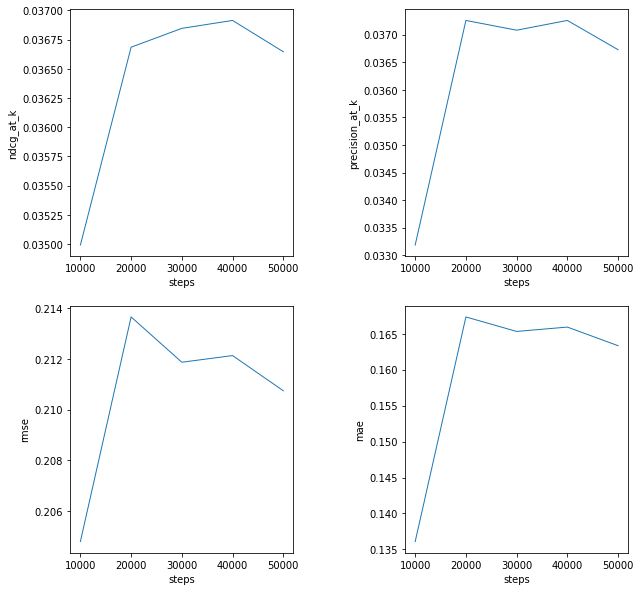

In [16]:
if EVALUATE_WHILE_TRAINING:
    logs = evaluation_logger.get_log()
    for i, (m, v) in enumerate(logs.items(), 1):
        sb.glue("eval_{}".format(m), v)
        x = [save_checkpoints_steps*i for i in range(1, len(v)+1)]
        plot.line_graph(
            values=list(zip(v, x)),
            labels=m,
            x_name="steps",
            y_name=m,
            subplot=(math.ceil(len(logs)/2), 2, i),
        )

#### 3.2 TensorBoard

Once the train is done, you can browse the details of the training results as well as the metrics we logged from [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard).

[]()|[]()|[]()
:---:|:---:|:---:
<img src="https://recodatasets.z20.web.core.windows.net/images/tensorboard_0.png?sanitize=true"> |  <img src="https://recodatasets.z20.web.core.windows.net/images/tensorboard_1.png?sanitize=true"> | <img src="https://recodatasets.z20.web.core.windows.net/images/tensorboard_2.png?sanitize=true">

To open the TensorBoard, open a terminal from the same directory of this notebook, run `tensorboard --logdir=model_checkpoints`, and open http://localhost:6006 from a browser.



### 4. Test and Export Model

#### 4.1 Item rating prediction

In [17]:
if len(RATING_METRICS) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=test)))
    prediction_df = test.drop(RATING_COL, axis=1)
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]
    
    rating_results = {}
    for m in RATING_METRICS:
        result = evaluator.metrics[m](test, prediction_df, **cols)
        sb.glue(m, result)
        rating_results[m] = result
    print(rating_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\kazim\Sources\senvaitis\recommenders\examples\00_quick_start\outputs\tensorboard\model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'rmse': 0.21074663242706482, 'mae': 0.16334591090231237}


#### 4.2 Recommend k items
For top-k recommendation evaluation, we use the ranking pool (all the user-item pairs) we prepared at the [training step](#ranking-pool). The difference is we remove users' seen items from the pool in this step which is more natural to the movie recommendation scenario.

In [18]:
if len(RANKING_METRICS) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=ranking_pool)))
    prediction_df = ranking_pool.copy()
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]

    ranking_results = {}
    for m in RANKING_METRICS:
        result = evaluator.metrics[m](test, prediction_df, **{**cols, 'k': TOP_K})
        sb.glue(m, result)
        ranking_results[m] = result
    print(ranking_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\kazim\Sources\senvaitis\recommenders\examples\00_quick_start\outputs\tensorboard\model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'ndcg_at_k': 0.03664649844098063, 'precision_at_k': 0.03672566371681416}


#### 4.3 Export Model
Finally, we export the model so that we can load later for re-training, evaluation, and prediction.
Examples of how to load, re-train, and evaluate the saved model can be found from [azureml_hyperdrive_wide_and_deep.ipynb](../04_model_select_and_optimize/azureml_hyperdrive_wide_and_deep.ipynb) notebook.

In [19]:
os.makedirs(EXPORT_DIR_BASE, exist_ok=True)

In [20]:
exported_path = tf_utils.export_model(
    model=model,
    train_input_fn=train_fn,
    eval_input_fn=tf_utils.pandas_input_fn(
        df=test, y_col=RATING_COL
    ),
    tf_feat_cols=wide_columns+deep_columns,
    base_dir=EXPORT_DIR_BASE
)
sb.glue('saved_model_dir', str(exported_path))
print("Model exported to", str(exported_path))

Model exported to .\outputs\model\1652675426


In [21]:
# Close the event file so that the model folder can be cleaned up.
summary_writer = tf.compat.v1.summary.FileWriterCache.get(model.model_dir)
summary_writer.close()

# Cleanup temporary directory if used
if TMP_DIR is not None:
    TMP_DIR.cleanup()